# Tuning the best architecture found
After performing the tuning for the base architecture for the model, the fianl step is to tune its hyper parameters. In this document, the implementation of this process is illustrated. The initial cells only show dataset and environment setup, which is the reason why no additional information supplied about them.

In [1]:
import tensorflow as tf
from data.data_utils import Dataset, save_dataset
import os
from model import AgeModel
import tensorflow.keras.losses as losses

# Set following config to resolve GPU errors
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
sess.as_default()
print("Tensorflow version used: {}".format(tf.__version__))

Tensorflow version used: 2.3.0


In [2]:
from tensorflow.python.client import device_lib
def check_if_gpu_used():
    gpu_names = [x.name for x in device_lib.list_local_devices() if x.device_type == 'GPU']
    if len(gpu_names) >= 1:
        print("Number of GPUs used by Tensorflow: {}".format(len(gpu_names)))
    else:
        print("Tensorflow operates on CPU now.")
check_if_gpu_used()

Number of GPUs used by Tensorflow: 1


In [3]:
import h5py
import numpy as np
from time import time
data_path = os.path.join(os.getcwd(), 'data')
datafile_path = os.path.join(data_path, "dataset.h5")
#save_dataset(data_path, dataset) # Compressing data in h5 format
start = time()
f = h5py.File(datafile_path, "r")
train_samples = np.array(f["train_samples"])
train_labels = np.array(f["train_labels"])
val_samples = np.array(f["val_samples"])
val_labels = np.array(f["val_labels"])
test_samples = np.array(f["test_samples"])
test_labels = np.array(f["test_labels"])
end = time()
f.close()
print("Monitoring compressed data details")
## Training set
print("Training data shape: {}".format(train_samples.shape))
print("Training labels shape: {}".format(train_labels.shape))
## Validation set
print("Validation data shape: {}".format(val_samples.shape))
print("Validation labels shape: {}".format(val_labels.shape))
## Test set
print("Testing data shape: {}".format(test_samples.shape))
print("Testing labels shape: {}".format(test_labels.shape))
print("Time to construct the dataset from compressed file: {:.3f} seconds".format(end - start))

Monitoring compressed data details
Training data shape: (5400, 91, 91, 1)
Training labels shape: (5400,)
Validation data shape: (2315, 91, 91, 1)
Validation labels shape: (2315,)
Testing data shape: (1159, 91, 91, 1)
Testing labels shape: (1159,)
Time to construct the dataset from compressed file: 0.776 seconds


## The non regularized model
As a result of the optimization performed for the previous part, the architecture specification is given below. Here this structure does not involve any kind of regularization

In [4]:
# Model specification
non_regularized_model = []
non_regularized_model.append({"type": "conv2d", "filters": 32, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "conv2d", "filters": 32, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None,"reg_ratio": None})
non_regularized_model.append({"type": "pool", "pool_type": "max", "pool_size": (2,2), "strides": None, "padding": "valid"})
non_regularized_model.append({"type": "conv2d", "filters": 64, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "conv2d", "filters": 64, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "pool", "pool_type": "max", "pool_size": (2,2), "strides": None, "padding": "valid"})
non_regularized_model.append({"type": "conv2d", "filters": 128, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "conv2d", "filters": 128, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "conv2d", "filters": 128, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "pool", "pool_type": "max", "pool_size": (2,2), "strides": None, "padding": "valid"})
non_regularized_model.append({"type": "conv2d", "filters": 256, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "conv2d", "filters": 512, "kernel_size": (1,1), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "pool", "pool_type": "max", "pool_size": (2,2), "strides": None, "padding": "valid"})
non_regularized_model.append({"type": "flatten"})
non_regularized_model.append({"type": "dense", "units": 256, "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "dense", "units": 128, "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "dense", "units": 64, "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "dense", "units": 1, "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})

Resulting from the findings for the previous stage, the final model includes batch normalization (at each convolutional layer) and L2 regularization. This modification is performed via the function given in the next cell.

In [5]:
def get_candidate_model(template_model, reg_ratio):
    model = template_model.copy()
    for layer in model:
        if layer["type"] in ("conv2d", "dense"):
            layer["regularizer"] = "l2"
            layer["reg_ratio"] = reg_ratio
            if layer["type"] == "conv2d":
                layer["batch_norm"] = True
    return model

### Visual representation of the model
To obtain an elegant visualization of the model, we used visualkeras library. This library visualizes the proposed network in terms of blocks. The full figure is provided in the assignment report.

In [15]:
!pip install visualkeras
import visualkeras
import matplotlib.pyplot as plt

def visualize_model(template_model):
    model = template_model.copy()
    model = get_candidate_model(model, 1e-4)
    age_model = AgeModel(model, "channels_last")
    age_model.build_comp_graph((None, 91, 91, 1))
    visualkeras.layered_view(age_model).show()

In [38]:
def visualize_experiment(history):
    losses = history.history["loss"]
    valid_losses = history.history["val_loss"]
    print("Training loss for experiment: {}".format(losses[-1]))
    print("Minimum validation loss value achieved: {}, the epoch it achieved: {}".format(np.amin(valid_losses), np.argmin(valid_losses)))
    plt.plot(range(1, len(losses) + 1), losses, color="blue", label="Training Loss")
    plt.plot(range(1, len(losses) + 1), valid_losses, color="orange", label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss plot for best model candidate")
    plt.legend(loc="upper right")

### Initial Attempt for training
As our first attempt to train the proposed model, we tried to train the network with a small amount of regularization and a sensible learning rate which are $10^{-5}$ and $10^{-4}$, respectively. This initial training is performed for 100 epochs.

In [18]:
def initial_training(layer_details, train_data, val_data, lr):
    exp_model = AgeModel(layer_details, "channels_last")
    exp_model.build_comp_graph((None, 91, 91, 1))
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.MeanAbsoluteError()
    exp_model.compile(loss=loss, optimizer=optim)
    history = exp_model.fit(x=train_data[0], y=train_data[1], epochs=100, verbose=2, validation_data=val_data)
    return history

In [21]:
init_model = get_candidate_model(non_regularized_model, 1e-5)
init_hist = initial_training(init_model, (train_samples, train_labels), (val_samples, val_labels), 1e-4)

Epoch 1/100
169/169 - 10s - loss: 12.9956 - val_loss: 26.4040
Epoch 2/100
169/169 - 10s - loss: 8.7763 - val_loss: 19.3482
Epoch 3/100
169/169 - 10s - loss: 7.4928 - val_loss: 10.3039
Epoch 4/100
169/169 - 10s - loss: 6.6037 - val_loss: 8.5186
Epoch 5/100
169/169 - 10s - loss: 5.9014 - val_loss: 8.4753
Epoch 6/100
169/169 - 10s - loss: 5.0930 - val_loss: 7.3438
Epoch 7/100
169/169 - 10s - loss: 4.6160 - val_loss: 7.5056
Epoch 8/100
169/169 - 10s - loss: 4.2630 - val_loss: 7.0929
Epoch 9/100
169/169 - 10s - loss: 3.8945 - val_loss: 7.3493
Epoch 10/100
169/169 - 10s - loss: 3.7120 - val_loss: 6.9336
Epoch 11/100
169/169 - 10s - loss: 3.4341 - val_loss: 7.2769
Epoch 12/100
169/169 - 10s - loss: 3.1219 - val_loss: 7.0512
Epoch 13/100
169/169 - 10s - loss: 3.1811 - val_loss: 7.0673
Epoch 14/100
169/169 - 10s - loss: 2.8773 - val_loss: 7.3817
Epoch 15/100
169/169 - 10s - loss: 2.9364 - val_loss: 7.2982
Epoch 16/100
169/169 - 10s - loss: 2.8177 - val_loss: 7.3536
Epoch 17/100
169/169 - 10s - 

Training loss for experiment: 1.241682767868042
Minimum validation loss value achieved: 6.128556251525879


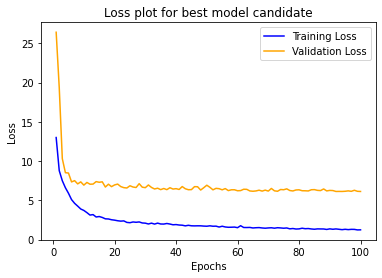

In [22]:
visualize_experiment(init_hist)

In [23]:
from tqdm import tqdm

## Optimizing the learning rate and regularization
Just like it was illustrated in the previous part, we performed hyperparameter tuning in log space for the quantities to be optimized. Also in order to perform experiments that do not miss any kind of meaningful alternatives, the alternative points are sampled from an uniform random distribution. The initial range for the learning rate is between $10^{-6}$ and $10^{-3}$ whereas this range is between $10^{-6}$ and $10^{1}$ for regularization parameter.

In [24]:
def optimize_lr_reg(step_count, template_model, training_samples, training_labels, valid_samples, valid_labels):
    lr_exp = np.random.uniform(-6, -3, step_count)
    reg_exp = np.random.uniform(-6, 1, step_count)
    random_idx = np.random.permutation(training_samples.shape[0])
    results = []
    # Results stored as (val_loss, train_loss, lr, reg_ratio)
    for exp_idx in tqdm(range(step_count)):
        model_metadata = get_candidate_model(template_model, 10**reg_exp[exp_idx])
        exp_model = AgeModel(model_metadata, "channels_last")
        exp_model.build_comp_graph((None, 91, 91, 1))
        optim = tf.keras.optimizers.Adam(learning_rate=10**lr_exp[exp_idx])
        loss = tf.keras.losses.MeanAbsoluteError()
        exp_model.compile(loss=loss, optimizer=optim)
        history = exp_model.fit(x=training_samples[random_idx[:500]], y=training_labels[random_idx[:500]], epochs=5, verbose=0, validation_data=(valid_samples, valid_labels))
        results.append((history.history["val_loss"][-1], history.history["loss"][-1], lr_exp[exp_idx], reg_exp[exp_idx]))
    results.sort(key=lambda x: x[0])
    return results
opt_results = optimize_lr_reg(50, non_regularized_model, train_samples, train_labels, val_samples, val_labels)

100%|██████████| 50/50 [10:06<00:00, 12.12s/it]


In [25]:
print("Best results obtained")
for result in opt_results[:10]:
    print("Valid Loss: {:.3f}, Train Loss: {:.3f}, lr: {:.3f}, reg ratio: {:.3f}".format(result[0], result[1], result[2], result[3]))

Best results obtained
Valid Loss: 23.712, Train Loss: 10.134, lr: -3.016, reg ratio: -5.166
Valid Loss: 26.273, Train Loss: 8.827, lr: -3.738, reg ratio: -4.034
Valid Loss: 27.617, Train Loss: 11.364, lr: -3.228, reg ratio: -3.328
Valid Loss: 28.286, Train Loss: 9.242, lr: -3.854, reg ratio: -4.779
Valid Loss: 28.562, Train Loss: 9.719, lr: -3.079, reg ratio: -4.757
Valid Loss: 28.938, Train Loss: 13.627, lr: -4.334, reg ratio: -4.344
Valid Loss: 28.940, Train Loss: 8.211, lr: -3.788, reg ratio: -4.093
Valid Loss: 29.121, Train Loss: 13.370, lr: -4.350, reg ratio: -4.106
Valid Loss: 29.334, Train Loss: 17.359, lr: -4.697, reg ratio: -4.903
Valid Loss: 29.519, Train Loss: 11.051, lr: -4.123, reg ratio: -4.738


After the first pass of the experiment the range for both the learning rate and regularization constant is adjusted into  between $10^{-5}$ and $10^{-3}$.

In [26]:
def lr_reg_smaller_range(step_count, template_model, training_samples, training_labels, valid_samples, valid_labels):
    lr_exp = np.random.uniform(-5, -3, step_count)
    reg_exp = np.random.uniform(-5, -3, step_count)
    random_idx = np.random.permutation(training_samples.shape[0])
    results = []
    # Results stored as (val_loss, train_loss, lr, reg_ratio)
    for exp_idx in tqdm(range(step_count)):
        model_metadata = get_candidate_model(template_model, 10**reg_exp[exp_idx])
        exp_model = AgeModel(model_metadata, "channels_last")
        exp_model.build_comp_graph((None, 91, 91, 1))
        optim = tf.keras.optimizers.Adam(learning_rate=10**lr_exp[exp_idx])
        loss = tf.keras.losses.MeanAbsoluteError()
        exp_model.compile(loss=loss, optimizer=optim)
        history = exp_model.fit(x=training_samples[random_idx[:500]], y=training_labels[random_idx[:500]], epochs=5, verbose=0, validation_data=(valid_samples, valid_labels))
        results.append((history.history["val_loss"][-1], history.history["loss"][-1], lr_exp[exp_idx], reg_exp[exp_idx]))
    results.sort(key=lambda x: x[0])
    return results

In [27]:
opt_stage_2 = lr_reg_smaller_range(20, non_regularized_model, train_samples, train_labels, val_samples, val_labels)

100%|██████████| 20/20 [04:04<00:00, 12.21s/it]


In [28]:
print("Best results obtained")
for result in opt_stage_2[:10]:
    print("Valid Loss: {:.3f}, Train Loss: {:.3f}, lr: {:.3f}, reg ratio: {:.3f}".format(result[0], result[1], result[2], result[3]))

Best results obtained
Valid Loss: 27.296, Train Loss: 8.948, lr: -3.982, reg ratio: -4.701
Valid Loss: 27.883, Train Loss: 12.427, lr: -4.548, reg ratio: -4.566
Valid Loss: 28.000, Train Loss: 7.971, lr: -3.494, reg ratio: -4.599
Valid Loss: 28.626, Train Loss: 13.358, lr: -4.543, reg ratio: -4.213
Valid Loss: 29.190, Train Loss: 11.189, lr: -4.252, reg ratio: -3.923
Valid Loss: 29.224, Train Loss: 14.278, lr: -4.583, reg ratio: -4.660
Valid Loss: 29.475, Train Loss: 13.597, lr: -4.615, reg ratio: -3.338
Valid Loss: 29.668, Train Loss: 11.160, lr: -4.217, reg ratio: -3.626
Valid Loss: 30.110, Train Loss: 13.158, lr: -4.398, reg ratio: -4.539
Valid Loss: 30.517, Train Loss: 10.186, lr: -3.116, reg ratio: -3.772


As the result of our observations, we decided to set the regularization parameter and the learning rate as $10^{-4}$. This setting is kept constatnt for all of the further experimentations.

In [29]:
visualize_model(non_regularized_model)

In [30]:
init_model = get_candidate_model(non_regularized_model, 1e-4)
init_hist = initial_training(init_model, (train_samples, train_labels), (val_samples, val_labels), 1e-4)

Epoch 1/100
169/169 - 10s - loss: 12.6721 - val_loss: 27.9794
Epoch 2/100
169/169 - 10s - loss: 8.8214 - val_loss: 15.0125
Epoch 3/100
169/169 - 10s - loss: 7.6603 - val_loss: 10.3754
Epoch 4/100
169/169 - 10s - loss: 6.6299 - val_loss: 8.2746
Epoch 5/100
169/169 - 10s - loss: 5.9734 - val_loss: 9.5610
Epoch 6/100
169/169 - 10s - loss: 5.3663 - val_loss: 7.6394
Epoch 7/100
169/169 - 10s - loss: 4.7483 - val_loss: 8.0911
Epoch 8/100
169/169 - 10s - loss: 4.2489 - val_loss: 7.7820
Epoch 9/100
169/169 - 10s - loss: 4.0203 - val_loss: 7.6145
Epoch 10/100
169/169 - 10s - loss: 3.7356 - val_loss: 7.1183
Epoch 11/100
169/169 - 10s - loss: 3.5171 - val_loss: 7.4921
Epoch 12/100
169/169 - 10s - loss: 3.3902 - val_loss: 7.4214
Epoch 13/100
169/169 - 10s - loss: 3.2244 - val_loss: 8.1357
Epoch 14/100
169/169 - 10s - loss: 3.1984 - val_loss: 7.3332
Epoch 15/100
169/169 - 10s - loss: 2.9090 - val_loss: 7.7323
Epoch 16/100
169/169 - 10s - loss: 2.8720 - val_loss: 6.9537
Epoch 17/100
169/169 - 10s - 

Training loss for experiment: 1.3311221599578857
Minimum validation loss value achieved: 6.191916465759277


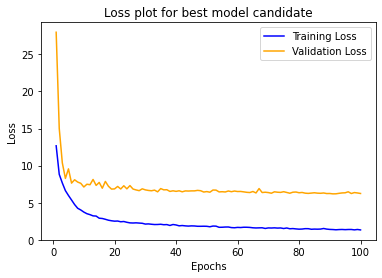

In [31]:
visualize_experiment(init_hist)

## Overtraining the model
In order to see the effect of overtraining the model, we trained our model for 800 epochs. While performing this process, in the case of the model overfits to the training set, we saved the model with the best validation loss as a model checkpoint as it occurs.

In [47]:
# Final Training
checkpoint_filepath = "tmp/checkpoint"
stopping_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min')
model_metadata = get_candidate_model(non_regularized_model, 1e-4)
model = AgeModel(model_metadata, "channels_last")
model.build_comp_graph((None, 91, 91, 1))
optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.MeanAbsoluteError()
model.compile(loss=loss, optimizer=optim)
history = model.fit(x=train_samples, y=train_labels, epochs=800, verbose=2, validation_data=(val_samples, val_labels), callbacks=[stopping_callback])

Epoch 1/800
169/169 - 10s - loss: 13.0714 - val_loss: 25.8332
Epoch 2/800
169/169 - 10s - loss: 9.0740 - val_loss: 16.6585
Epoch 3/800
169/169 - 10s - loss: 7.8749 - val_loss: 10.1027
Epoch 4/800
169/169 - 10s - loss: 6.8738 - val_loss: 9.3555
Epoch 5/800
169/169 - 10s - loss: 6.1186 - val_loss: 8.6587
Epoch 6/800
169/169 - 10s - loss: 5.4033 - val_loss: 7.7500
Epoch 7/800
169/169 - 10s - loss: 5.1224 - val_loss: 7.6146
Epoch 8/800
169/169 - 10s - loss: 4.4667 - val_loss: 7.9977
Epoch 9/800
169/169 - 10s - loss: 4.1578 - val_loss: 8.0332
Epoch 10/800
169/169 - 10s - loss: 3.9103 - val_loss: 7.5427
Epoch 11/800
169/169 - 10s - loss: 3.6215 - val_loss: 7.6880
Epoch 12/800
169/169 - 10s - loss: 3.4643 - val_loss: 7.5426
Epoch 13/800
169/169 - 10s - loss: 3.3146 - val_loss: 7.3728
Epoch 14/800
169/169 - 10s - loss: 3.1168 - val_loss: 8.1672
Epoch 15/800
169/169 - 10s - loss: 3.1077 - val_loss: 7.3628
Epoch 16/800
169/169 - 10s - loss: 2.9790 - val_loss: 7.0300
Epoch 17/800
169/169 - 10s - 

Epoch 135/800
169/169 - 10s - loss: 1.1636 - val_loss: 6.2920
Epoch 136/800
169/169 - 10s - loss: 1.1627 - val_loss: 6.4083
Epoch 137/800
169/169 - 10s - loss: 1.1643 - val_loss: 6.3449
Epoch 138/800
169/169 - 10s - loss: 1.2304 - val_loss: 6.3366
Epoch 139/800
169/169 - 10s - loss: 1.1637 - val_loss: 6.2845
Epoch 140/800
169/169 - 10s - loss: 1.1266 - val_loss: 6.3235
Epoch 141/800
169/169 - 10s - loss: 1.1664 - val_loss: 6.3000
Epoch 142/800
169/169 - 10s - loss: 1.2293 - val_loss: 6.2767
Epoch 143/800
169/169 - 10s - loss: 1.1595 - val_loss: 6.3288
Epoch 144/800
169/169 - 10s - loss: 1.1571 - val_loss: 6.2926
Epoch 145/800
169/169 - 10s - loss: 1.1271 - val_loss: 6.3799
Epoch 146/800
169/169 - 10s - loss: 1.1771 - val_loss: 6.3968
Epoch 147/800
169/169 - 10s - loss: 1.1485 - val_loss: 6.4646
Epoch 148/800
169/169 - 10s - loss: 1.1439 - val_loss: 6.4011
Epoch 149/800
169/169 - 10s - loss: 1.1006 - val_loss: 6.3053
Epoch 150/800
169/169 - 10s - loss: 1.1134 - val_loss: 6.2692
Epoch 15

169/169 - 10s - loss: 0.8126 - val_loss: 6.2545
Epoch 268/800
169/169 - 10s - loss: 0.8431 - val_loss: 6.3402
Epoch 269/800
169/169 - 10s - loss: 0.8215 - val_loss: 6.3108
Epoch 270/800
169/169 - 10s - loss: 0.8348 - val_loss: 6.2911
Epoch 271/800
169/169 - 10s - loss: 0.8388 - val_loss: 6.3332
Epoch 272/800
169/169 - 10s - loss: 0.8095 - val_loss: 6.3289
Epoch 273/800
169/169 - 10s - loss: 0.8331 - val_loss: 6.4066
Epoch 274/800
169/169 - 10s - loss: 0.8018 - val_loss: 6.2263
Epoch 275/800
169/169 - 10s - loss: 0.8083 - val_loss: 6.2706
Epoch 276/800
169/169 - 10s - loss: 0.8326 - val_loss: 6.3556
Epoch 277/800
169/169 - 10s - loss: 0.7886 - val_loss: 6.3360
Epoch 278/800
169/169 - 10s - loss: 0.7907 - val_loss: 6.2174
Epoch 279/800
169/169 - 10s - loss: 0.8064 - val_loss: 6.2269
Epoch 280/800
169/169 - 10s - loss: 0.7993 - val_loss: 6.3227
Epoch 281/800
169/169 - 10s - loss: 0.7921 - val_loss: 6.3215
Epoch 282/800
169/169 - 10s - loss: 0.7905 - val_loss: 6.3091
Epoch 283/800
169/169 

Epoch 400/800
169/169 - 10s - loss: 0.6803 - val_loss: 6.2704
Epoch 401/800
169/169 - 10s - loss: 0.6773 - val_loss: 6.2971
Epoch 402/800
169/169 - 10s - loss: 0.6891 - val_loss: 6.2484
Epoch 403/800
169/169 - 10s - loss: 0.6879 - val_loss: 6.3185
Epoch 404/800
169/169 - 10s - loss: 0.6452 - val_loss: 6.2566
Epoch 405/800
169/169 - 10s - loss: 0.6675 - val_loss: 6.2607
Epoch 406/800
169/169 - 10s - loss: 0.6791 - val_loss: 6.2309
Epoch 407/800
169/169 - 10s - loss: 0.6815 - val_loss: 6.2497
Epoch 408/800
169/169 - 10s - loss: 0.6629 - val_loss: 6.2435
Epoch 409/800
169/169 - 10s - loss: 0.6662 - val_loss: 6.2773
Epoch 410/800
169/169 - 10s - loss: 0.6846 - val_loss: 6.2343
Epoch 411/800
169/169 - 10s - loss: 0.6771 - val_loss: 6.3427
Epoch 412/800
169/169 - 10s - loss: 0.6701 - val_loss: 6.3050
Epoch 413/800
169/169 - 10s - loss: 0.6729 - val_loss: 6.3023
Epoch 414/800
169/169 - 10s - loss: 0.6894 - val_loss: 6.9231
Epoch 415/800
169/169 - 10s - loss: 0.6674 - val_loss: 6.2756
Epoch 41

169/169 - 10s - loss: 0.5939 - val_loss: 6.2223
Epoch 533/800
169/169 - 10s - loss: 0.5989 - val_loss: 6.2711
Epoch 534/800
169/169 - 10s - loss: 0.6061 - val_loss: 6.2452
Epoch 535/800
169/169 - 10s - loss: 0.6094 - val_loss: 6.1918
Epoch 536/800
169/169 - 10s - loss: 0.6012 - val_loss: 6.5276
Epoch 537/800
169/169 - 10s - loss: 0.5851 - val_loss: 6.3445
Epoch 538/800
169/169 - 10s - loss: 0.6002 - val_loss: 6.4622
Epoch 539/800
169/169 - 10s - loss: 0.6031 - val_loss: 6.2424
Epoch 540/800
169/169 - 10s - loss: 0.6008 - val_loss: 6.2615
Epoch 541/800
169/169 - 10s - loss: 0.6296 - val_loss: 6.3036
Epoch 542/800
169/169 - 10s - loss: 0.6244 - val_loss: 6.3728
Epoch 543/800
169/169 - 10s - loss: 0.5973 - val_loss: 6.3014
Epoch 544/800
169/169 - 10s - loss: 0.6071 - val_loss: 6.2749
Epoch 545/800
169/169 - 10s - loss: 0.6283 - val_loss: 6.3324
Epoch 546/800
169/169 - 10s - loss: 0.5999 - val_loss: 6.2515
Epoch 547/800
169/169 - 10s - loss: 0.6133 - val_loss: 6.2701
Epoch 548/800
169/169 

Epoch 665/800
169/169 - 10s - loss: 0.5524 - val_loss: 6.3441
Epoch 666/800
169/169 - 10s - loss: 0.5506 - val_loss: 6.2732
Epoch 667/800
169/169 - 10s - loss: 0.5403 - val_loss: 6.4622
Epoch 668/800
169/169 - 10s - loss: 0.5509 - val_loss: 6.2699
Epoch 669/800
169/169 - 10s - loss: 0.5578 - val_loss: 6.4026
Epoch 670/800
169/169 - 10s - loss: 0.5600 - val_loss: 6.1699
Epoch 671/800
169/169 - 10s - loss: 0.5900 - val_loss: 6.2584
Epoch 672/800
169/169 - 10s - loss: 0.5743 - val_loss: 6.2253
Epoch 673/800
169/169 - 10s - loss: 0.5841 - val_loss: 6.3876
Epoch 674/800
169/169 - 10s - loss: 0.5624 - val_loss: 6.2724
Epoch 675/800
169/169 - 10s - loss: 0.5777 - val_loss: 6.2096
Epoch 676/800
169/169 - 10s - loss: 0.5717 - val_loss: 6.3942
Epoch 677/800
169/169 - 10s - loss: 0.5581 - val_loss: 6.2482
Epoch 678/800
169/169 - 10s - loss: 0.5666 - val_loss: 6.2432
Epoch 679/800
169/169 - 10s - loss: 0.5436 - val_loss: 6.3003
Epoch 680/800
169/169 - 10s - loss: 0.5492 - val_loss: 6.2544
Epoch 68

169/169 - 10s - loss: 0.5289 - val_loss: 6.3450
Epoch 798/800
169/169 - 10s - loss: 0.5230 - val_loss: 6.4216
Epoch 799/800
169/169 - 10s - loss: 0.5296 - val_loss: 6.2708
Epoch 800/800
169/169 - 10s - loss: 0.5115 - val_loss: 6.2636


As indicated by the output, we saved the model at the $587^{th}$ epoch at the latest, which has the best validation score overall.

Training loss for experiment: 0.5114560723304749
Minimum validation loss value achieved: 6.166373252868652, the epoch it achieved: 587


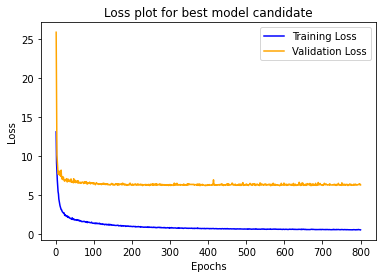

In [48]:
visualize_experiment(history)

## Stopping training early
Considering our finding when we overtrain our model, we saw that training loss faces no significant drop after epoch 600. Due to this fact, we performed early stopping as a regularizer stop prevent model from overtraining.

In [41]:
model_metadata = get_candidate_model(non_regularized_model, 1e-4)
cut_model = AgeModel(model_metadata, "channels_last")
cut_model.build_comp_graph((None, 91, 91, 1))
optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.MeanAbsoluteError()
cut_model.compile(loss=loss, optimizer=optim)
cut_history = cut_model.fit(x=train_samples, y=train_labels, epochs=600, verbose=2, validation_data=(val_samples, val_labels))
cut_model.save("tmp/cut_model")

Epoch 1/600
169/169 - 10s - loss: 12.9692 - val_loss: 25.0820
Epoch 2/600
169/169 - 10s - loss: 9.0855 - val_loss: 17.1403
Epoch 3/600
169/169 - 10s - loss: 7.8034 - val_loss: 9.9232
Epoch 4/600
169/169 - 10s - loss: 6.7004 - val_loss: 8.1719
Epoch 5/600
169/169 - 10s - loss: 5.9909 - val_loss: 8.2356
Epoch 6/600
169/169 - 10s - loss: 5.3682 - val_loss: 7.8369
Epoch 7/600
169/169 - 10s - loss: 4.9034 - val_loss: 7.7090
Epoch 8/600
169/169 - 10s - loss: 4.3527 - val_loss: 7.5272
Epoch 9/600
169/169 - 10s - loss: 4.0228 - val_loss: 7.6691
Epoch 10/600
169/169 - 10s - loss: 3.8647 - val_loss: 7.5174
Epoch 11/600
169/169 - 10s - loss: 3.6225 - val_loss: 7.4800
Epoch 12/600
169/169 - 10s - loss: 3.4102 - val_loss: 7.6439
Epoch 13/600
169/169 - 10s - loss: 3.2404 - val_loss: 7.5691
Epoch 14/600
169/169 - 10s - loss: 3.0687 - val_loss: 7.3098
Epoch 15/600
169/169 - 10s - loss: 3.1626 - val_loss: 7.3363
Epoch 16/600
169/169 - 10s - loss: 2.8865 - val_loss: 7.9575
Epoch 17/600
169/169 - 10s - l

Epoch 135/600
169/169 - 10s - loss: 1.1679 - val_loss: 6.3078
Epoch 136/600
169/169 - 10s - loss: 1.1760 - val_loss: 6.3041
Epoch 137/600
169/169 - 10s - loss: 1.1939 - val_loss: 6.3477
Epoch 138/600
169/169 - 10s - loss: 1.1881 - val_loss: 6.3949
Epoch 139/600
169/169 - 10s - loss: 1.1571 - val_loss: 6.3496
Epoch 140/600
169/169 - 10s - loss: 1.1569 - val_loss: 6.2982
Epoch 141/600
169/169 - 10s - loss: 1.1290 - val_loss: 6.3577
Epoch 142/600
169/169 - 10s - loss: 1.1919 - val_loss: 6.3504
Epoch 143/600
169/169 - 10s - loss: 1.1889 - val_loss: 6.3618
Epoch 144/600
169/169 - 10s - loss: 1.1795 - val_loss: 6.4399
Epoch 145/600
169/169 - 10s - loss: 1.1172 - val_loss: 6.4495
Epoch 146/600
169/169 - 10s - loss: 1.1344 - val_loss: 6.3428
Epoch 147/600
169/169 - 10s - loss: 1.1783 - val_loss: 6.3694
Epoch 148/600
169/169 - 10s - loss: 1.1316 - val_loss: 6.4760
Epoch 149/600
169/169 - 10s - loss: 1.1237 - val_loss: 6.4640
Epoch 150/600
169/169 - 10s - loss: 1.0945 - val_loss: 6.3212
Epoch 15

169/169 - 10s - loss: 0.7905 - val_loss: 6.3359
Epoch 268/600
169/169 - 10s - loss: 0.7828 - val_loss: 6.2736
Epoch 269/600
169/169 - 10s - loss: 0.8115 - val_loss: 6.3047
Epoch 270/600
169/169 - 10s - loss: 0.8230 - val_loss: 6.3653
Epoch 271/600
169/169 - 10s - loss: 0.7724 - val_loss: 6.2406
Epoch 272/600
169/169 - 10s - loss: 0.7790 - val_loss: 6.3057
Epoch 273/600
169/169 - 10s - loss: 0.7931 - val_loss: 6.1887
Epoch 274/600
169/169 - 10s - loss: 0.7855 - val_loss: 6.2491
Epoch 275/600
169/169 - 10s - loss: 0.7721 - val_loss: 6.3450
Epoch 276/600
169/169 - 10s - loss: 0.7539 - val_loss: 6.3302
Epoch 277/600
169/169 - 10s - loss: 0.7829 - val_loss: 6.2927
Epoch 278/600
169/169 - 10s - loss: 0.7538 - val_loss: 6.2001
Epoch 279/600
169/169 - 10s - loss: 0.7859 - val_loss: 6.3089
Epoch 280/600
169/169 - 10s - loss: 0.8115 - val_loss: 6.3269
Epoch 281/600
169/169 - 10s - loss: 0.7565 - val_loss: 6.3010
Epoch 282/600
169/169 - 10s - loss: 0.7693 - val_loss: 6.2787
Epoch 283/600
169/169 

Epoch 400/600
169/169 - 10s - loss: 0.6328 - val_loss: 6.2231
Epoch 401/600
169/169 - 10s - loss: 0.6624 - val_loss: 6.3109
Epoch 402/600
169/169 - 10s - loss: 0.6659 - val_loss: 6.3149
Epoch 403/600
169/169 - 10s - loss: 0.6508 - val_loss: 6.2484
Epoch 404/600
169/169 - 10s - loss: 0.6428 - val_loss: 6.2288
Epoch 405/600
169/169 - 10s - loss: 0.6436 - val_loss: 6.1436
Epoch 406/600
169/169 - 10s - loss: 0.6443 - val_loss: 6.2277
Epoch 407/600
169/169 - 10s - loss: 0.6623 - val_loss: 6.2172
Epoch 408/600
169/169 - 10s - loss: 0.6390 - val_loss: 6.2248
Epoch 409/600
169/169 - 10s - loss: 0.6433 - val_loss: 6.2391
Epoch 410/600
169/169 - 10s - loss: 0.6568 - val_loss: 6.2441
Epoch 411/600
169/169 - 10s - loss: 0.6413 - val_loss: 6.2624
Epoch 412/600
169/169 - 10s - loss: 0.6400 - val_loss: 6.2502
Epoch 413/600
169/169 - 10s - loss: 0.6670 - val_loss: 6.2585
Epoch 414/600
169/169 - 10s - loss: 0.6324 - val_loss: 6.2345
Epoch 415/600
169/169 - 10s - loss: 0.6342 - val_loss: 6.2860
Epoch 41

169/169 - 10s - loss: 0.5645 - val_loss: 6.2970
Epoch 533/600
169/169 - 10s - loss: 0.5868 - val_loss: 6.4335
Epoch 534/600
169/169 - 10s - loss: 0.5864 - val_loss: 6.2380
Epoch 535/600
169/169 - 10s - loss: 0.5916 - val_loss: 6.2966
Epoch 536/600
169/169 - 10s - loss: 0.6010 - val_loss: 6.3380
Epoch 537/600
169/169 - 10s - loss: 0.6113 - val_loss: 6.3210
Epoch 538/600
169/169 - 10s - loss: 0.5848 - val_loss: 6.2889
Epoch 539/600
169/169 - 10s - loss: 0.5975 - val_loss: 6.2696
Epoch 540/600
169/169 - 10s - loss: 0.5629 - val_loss: 6.2534
Epoch 541/600
169/169 - 10s - loss: 0.5721 - val_loss: 6.2467
Epoch 542/600
169/169 - 10s - loss: 0.5816 - val_loss: 6.2497
Epoch 543/600
169/169 - 10s - loss: 0.6038 - val_loss: 6.2682
Epoch 544/600
169/169 - 10s - loss: 0.5790 - val_loss: 6.2971
Epoch 545/600
169/169 - 10s - loss: 0.5704 - val_loss: 6.2724
Epoch 546/600
169/169 - 10s - loss: 0.5765 - val_loss: 6.2472
Epoch 547/600
169/169 - 10s - loss: 0.5623 - val_loss: 6.3046
Epoch 548/600
169/169 

Training loss for experiment: 0.5585809350013733
Minimum validation loss value achieved: 6.143649578094482, the epoch it achieved: 404


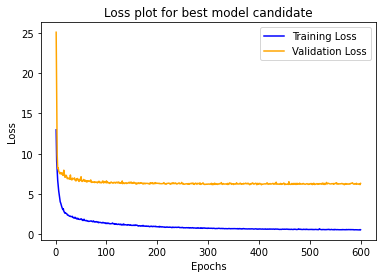

In [42]:
visualize_experiment(cut_history)

## Testing
Now that we have three different models, that gives us three options as our final model. Here the three model alternatives are tested against the test set (that they never saw before). According to our results, the model that we have applied early stopping is the best model with a small difference

In [74]:
# Model trained 1000 epochs
print("Evaluating model trained 800 epochs")
model.evaluate(x=test_samples, y=test_labels)

Evaluating model trained 800 epochs
37/37 [==============================] - 1s 16ms/step - loss: 6.4873


6.487283229827881

In [53]:
print("Evaluating model with best validation loss")
model_metadata = get_candidate_model(non_regularized_model, 1e-4)
loaded_model = AgeModel(model_metadata, "channels_last")
loaded_model.build_comp_graph((None, 91, 91, 1))
optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.MeanAbsoluteError()
loaded_model.compile(loss=loss, optimizer=optim)
loaded_model.load_weights(checkpoint_filepath)
loaded_model.evaluate(x=test_samples, y=test_labels)

Evaluating model with best validation loss
37/37 [==============================] - 1s 16ms/step - loss: 6.4862


6.486240863800049

In [54]:
print("Evaluating model trained 600 epochs")
cut_model.evaluate(x=test_samples, y=test_labels)

Evaluating model trained 600 epochs
37/37 [==============================] - 1s 15ms/step - loss: 6.4457


6.445735454559326

In [66]:
predictions = cut_model.predict(test_samples).flatten()
diff = np.absolute(predictions - test_labels)
sort_preds = np.argsort(diff)
best_predictions = sort_preds[:4]
worst_predictions = sort_preds[-4:]
best_images = test_samples[best_predictions][...]
worst_images = test_samples[worst_predictions][...]

### Visualizing failing and successful examples
Finalizing our assignment, we visualized the most accurate predictions and the least accurate predictions for our task. A more detailed discussion is provided in the assignment report.

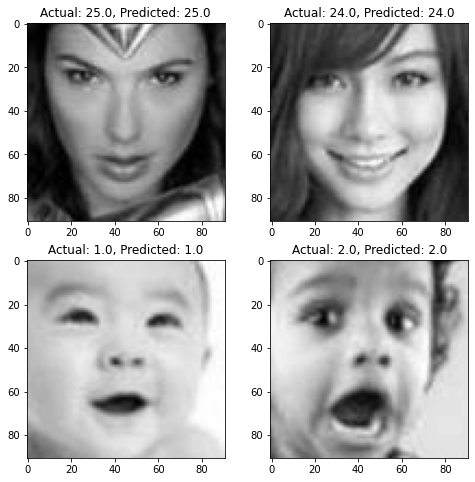

In [71]:
# Visualize Best Predictions
fig, axes = plt.subplots(2,2, figsize=(8,8))
predictions = np.array(predictions)
for img_idx in range(best_images.shape[0]):
    axes[img_idx // 2, img_idx % 2].imshow(best_images[img_idx], cmap="gray")
    axes[img_idx // 2, img_idx % 2].set_title("Actual: {}, Predicted: {:.1f}".format(test_labels[best_predictions[img_idx]], predictions[best_predictions[img_idx]]))

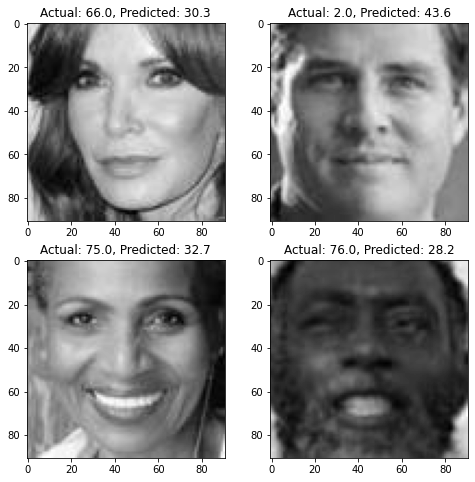

In [72]:
# Visualize Best Predictions
fig, axes = plt.subplots(2,2, figsize=(8,8))
for img_idx in range(worst_images.shape[0]):
    axes[img_idx // 2, img_idx % 2].imshow(worst_images[img_idx], cmap="gray")
    axes[img_idx // 2, img_idx % 2].set_title("Actual: {}, Predicted: {:.1f}".format(test_labels[worst_predictions[img_idx]], predictions[worst_predictions[img_idx]]))

In [73]:
cut_model.summary()

Model: "age_model_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_774 (Conv2D)          (None, 89, 89, 32)        320       
_________________________________________________________________
batch_normalization_774 (Bat (None, 89, 89, 32)        128       
_________________________________________________________________
activation_774 (Activation)  (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_775 (Conv2D)          (None, 87, 87, 32)        9248      
_________________________________________________________________
batch_normalization_775 (Bat (None, 87, 87, 32)        128       
_________________________________________________________________
activation_775 (Activation)  (None, 87, 87, 32)        0         
_________________________________________________________________
max_pooling2d_344 (MaxPoolin (None, 43, 43, 32)       

In [75]:
cut_model.save("tmp/cut_model")

INFO:tensorflow:Assets written to: tmp/cut_model\assets
